# Data Preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
trn_dirty = pd.read_csv("../data/processed/trn.dirty.csv")
trn_dirty.dropna(subset=['SMILES', 'Solubility'], inplace=True)
trn_dirty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1702 entries, 0 to 1787
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        1702 non-null   object 
 1   Solubility  1702 non-null   float64
 2   SMILES      1702 non-null   object 
 3   MW          1702 non-null   float64
dtypes: float64(2), object(2)
memory usage: 66.5+ KB


- **Mitigate the risk of duplication and pollution**
  In the absence of a straightforward criterion for defining and identifying duplicates, to mitigate the risk of polluting our training set with duplicates of test items, and to avoid using subjective comparisons, we have opted to exclude compounds with identical molecular weights (MW) as calculated by Chemistry Development Kit (CDK) software and specified to three decimal places.

In [21]:
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")

In [22]:
names = set(tst_08SC["Name"]).union(set(tst1_19SC["Name"])).union(set(tst2_19SC["Name"]))
smiles = set(tst_08SC["SMILES"]).union(set(tst1_19SC["SMILES"])).union(set(tst2_19SC["SMILES"]))

In [23]:
mw_set = (tst1_19SC["MW"].values.tolist() +
          tst2_19SC["MW"].values.tolist() +
          tst_08SC["MW"].values.tolist())
mw_set = set(map(lambda num: round(num, ndigits=3), mw_set))

idx_to_remove = trn_dirty[trn_dirty.apply(lambda row: round(row["MW"], ndigits=3) in mw_set, axis=1)].index
trn_cleaned = trn_dirty.drop(idx_to_remove)
trn_cleaned = trn_dirty.copy(deep=True)

In [24]:
trn_cleaned = trn_cleaned[~trn_cleaned['Name'].isin(names)]
trn_cleaned = trn_cleaned[~trn_cleaned['SMILES'].isin(smiles)]

In [ ]:
print(f"{len(trn_dirty) - len(trn_cleaned)} compounds are removed.")
trn_cleaned.to_csv("../data/processed/trn.csv", index=False)

In [ ]:
trn_cleaned.info()

In [ ]:
_, ax = plt.subplots(figsize=(5, 5))
sns.histplot(trn_dirty["Solubility"], kde=True, bins=50, ax=ax)
ax.set_xlabel("Log $S$ exp (mol/L)", fontsize=12)
ax.set_ylabel("count", fontsize=12)
plt.show()

## Featurization (Molecular Descriptors)

In [12]:
from featurization.base import BaseRepresentation
from featurization.rdkit import Rdkit2D
from featurization.mordred import Mordred
from featurization.MACCSKeys import MACCSKeys
from featurization.circular import Circular
from featurization.mol2vec import Mol2Vec


def featurize(featurizer: BaseRepresentation, df):
    return featurizer.convert(df["SMILES"]).add_prefix(featurizer.__class__.__name__)

In [13]:
trn = pd.read_csv("../data/processed/trn.csv")
pd.concat([
    trn,
    featurize(Rdkit2D(), trn),
    featurize(Mordred(), trn),
    featurize(MACCSKeys(), trn),
    featurize(Circular(), trn),
], axis=1).to_csv("../data/processed/trn.feat.csv", index=False)


To complete installation of Oloren ChemEngine, either:
    (1) Install the missing dependencies, these can be found by calling oce.MISSING_DEPENDENCIES(), or
    (2) Email contact@oloren.ai with subject "Oloren ChemEngine Enterprise", for a secure privately hosted
        Server version.

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [19]:
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
pd.concat([
    tst_08SC,
    featurize(Rdkit2D(), tst_08SC),
    featurize(Mordred(), tst_08SC),
    featurize(MACCSKeys(), tst_08SC),
    featurize(Circular(), tst_08SC),
], axis=1).to_csv("../data/processed/tst.08SC.feat.csv", index=False)

In [21]:
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
pd.concat([
    tst1_19SC,
    featurize(Rdkit2D(), tst1_19SC),
    featurize(Mordred(), tst1_19SC),
    featurize(MACCSKeys(), tst1_19SC),
    featurize(Circular(), tst1_19SC),
], axis=1).to_csv("../data/processed/tst.19SC.1.feat.csv", index=False)

In [23]:
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")
pd.concat([
    tst2_19SC,
    featurize(Rdkit2D(), tst2_19SC),
    featurize(Mordred(), tst2_19SC),
    featurize(MACCSKeys(), tst2_19SC),
    featurize(Circular(), tst2_19SC),
], axis=1).to_csv("../data/processed/tst.19SC.2.feat.csv", index=False)

In [2]:
trn = pd.read_csv("../data/processed/trn.feat.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.feat.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.feat.csv")

In [3]:
trn_y, trn_X = trn["Solubility"], trn.drop(["Solubility", "Name", "SMILES"], axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop(["Solubility", "Name", "SMILES"], axis=1)

<AxesSubplot: >

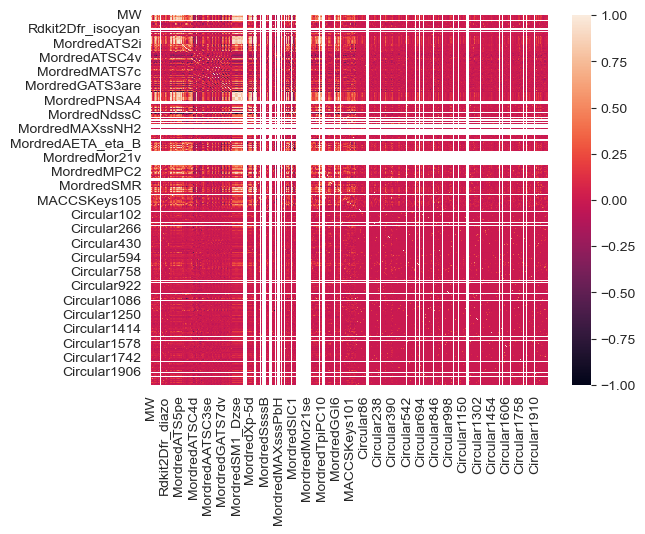

In [6]:
sns.heatmap(trn_X.corr())

## Visualization using Dimensionality Reduction

In [4]:
import umap, umap.plot
from sklearn.manifold import TSNE

C:\Users\ecbur\miniconda3\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [21]:
reducer = umap.UMAP(
    n_neighbors=35,
    min_dist=0.4,
    n_epochs=500,
    random_state=1024
).fit(trn_X)
embedding = reducer.transform(trn_X)
embedding = pd.DataFrame(embedding, columns=["UMAP 1", "UMAP 2"])
embedding["Solubility"] = trn_y

C:\Users\ecbur\miniconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


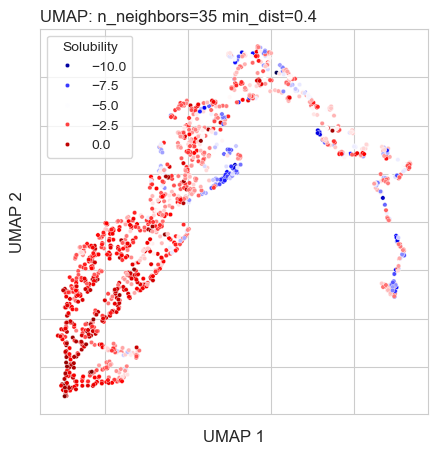

In [35]:
_, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(embedding, x="UMAP 1", y="UMAP 2", hue="Solubility", s=10, palette="seismic")
ax.set_xlabel("UMAP 1", fontsize=12)
ax.set_ylabel("UMAP 2", fontsize=12)
ax.text(0, 1.05,
        f"UMAP: n_neighbors={reducer.n_neighbors} min_dist={reducer.min_dist}",
        fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

In [38]:
reducer = TSNE(
    n_components=2,
    perplexity=25,
    random_state=1024
)
embedding = reducer.fit_transform(trn_X)
embedding = pd.DataFrame(embedding, columns=["t-SNE 1", "t-SNE 2"])
embedding["Solubility"] = trn_y

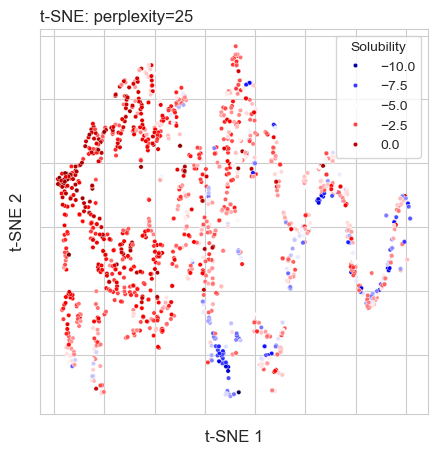

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(embedding, x="t-SNE 1", y="t-SNE 2", hue="Solubility", s=10, palette="seismic")
ax.set_xlabel("t-SNE 1", fontsize=12)
ax.set_ylabel("t-SNE 2", fontsize=12)
ax.text(0, 1.05,
        f"t-SNE: perplexity={reducer.perplexity}",
        fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

## Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
trn_X = pd.DataFrame(scaler.fit_transform(trn_X), columns=trn_X.columns)

In [ ]:
tst_08SC_X = pd.DataFrame(scaler.transform(tst_08SC_X), columns=tst_08SC_X.columns)
tst1_19SC_X = pd.DataFrame(scaler.transform(tst1_19SC_X), columns=tst1_19SC_X.columns)
tst2_19SC_X = pd.DataFrame(scaler.transform(tst2_19SC_X), columns=tst2_19SC_X.columns)

In [ ]:
pd.concat([trn_y, trn_X], axis=1).to_csv("../data/normalized/TRN.csv", index=False)
pd.concat([tst_08SC_y, tst_08SC_X], axis=1).to_csv("../data/normalized/TST_2008SC.csv", index=False)
pd.concat([tst1_19SC_y, tst1_19SC_X], axis=1).to_csv("../data/normalized/TST1_2019SC.csv", index=False)
pd.concat([tst2_19SC_y, tst2_19SC_X], axis=1).to_csv("../data/normalized/TST2_2019SC.csv", index=False)

## Feature Importance

In [ ]:
trn = pd.read_csv("../data/normalized/TRN.csv")
tst_08SC = pd.read_csv("../data/normalized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/normalized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/normalized/TST2_2019SC.csv")

trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [ ]:
import xgboost as xgb
from sklearn.inspection import permutation_importance
import shap

In [ ]:
params = {
    "eta": 0.1,
    "gamma": 1.1055210927423804,
    "alpha": 42.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",
    "seed": 1234,

    "num_boost_round": 100,
    "early_stopping_rounds": 10,
    "nfold": 5
}

In [ ]:
booster = xgb.XGBRegressor(
    n_estimators=params["num_boost_round"],
    max_depth=params["max_depth"],
    learning_rate=params["eta"],
    objective=params["objective"],
    booster=params["booster"],
    tree_method=params["tree_method"],
    gamma=params["gamma"],
    min_child_weight=params["min_child_weight"],
    colsample_bytree=params["colsample_bytree"],
    reg_alpha=params["alpha"],
    reg_lambda=params["lambda"],
    random_state=params["seed"],
    device=params["device"],
)
booster.fit(trn_X, trn_y)

### Permutation Feature Importance

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pi_tst1_19SC = permutation_importance(booster, tst1_19SC_X, tst1_19SC_y)
pd.DataFrame(pi_tst1_19SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst1_19SC.csv", index=False)

In [ ]:
pi_tst2_19SC = permutation_importance(booster, tst2_19SC_X, tst2_19SC_y)
pd.DataFrame(pi_tst2_19SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst2_19SC.csv", index=False)

In [ ]:
pi_tst_08SC = permutation_importance(booster, tst_08SC_X, tst_08SC_y)
pd.DataFrame(pi_tst_08SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst_08SC.csv", index=False)

### SHAP Feature Importance

In [ ]:
explainer = shap.TreeExplainer(booster)
si_tst_08SC = explainer.shap_values(tst_08SC_X, tst_08SC_y)
si_tst1_19SC = explainer.shap_values(tst1_19SC_X, tst1_19SC_y)
si_tst2_19SC = explainer.shap_values(tst2_19SC_X, tst2_19SC_y)

### Plotting the results

In [ ]:
pi_tst_08SC = pd.read_csv("../data/feature_importance/pi_tst_08SC.csv").values
pi_tst1_19SC = pd.read_csv("../data/feature_importance/pi_tst1_19SC.csv").values
pi_tst2_19SC = pd.read_csv("../data/feature_importance/pi_tst2_19SC.csv").values
pi_mean = (pi_tst1_19SC + pi_tst2_19SC + pi_tst_08SC) / 3

In [ ]:
si_tst_08SC = np.abs(si_tst_08SC).mean(0)
si_tst1_19SC = np.abs(si_tst1_19SC).mean(0)
si_tst2_19SC = np.abs(si_tst2_19SC).mean(0)
si_mean = (si_tst_08SC + si_tst1_19SC + si_tst2_19SC) / 3

In [ ]:
top100_pi_idx = pi_mean.flatten().argsort()[::-1][:10]
top100_si_idx = si_mean.flatten().argsort()[::-1][:10]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.bar(trn_X.columns[top100_pi_idx], pi_mean[top100_pi_idx, 0].tolist())
ax1.set_xlabel("Molecular Descriptor")
ax1.set_ylabel("Permutation Importance")
ax1.tick_params(axis='x', labelrotation=90)

ax2.bar(trn_X.columns[top100_si_idx], si_mean[top100_si_idx].tolist())
ax2.set_xlabel("Molecular Descriptor")
ax2.set_ylabel("SHAP Importance")
ax2.tick_params(axis='x', labelrotation=90)

plt.tight_layout()

### Choosing a subset of the most important features

If the two importance arrays have different scales, it's inappropriate to average them directly.

Our strategy is to first normalize each set of importance so their values fall within the range [0, 1], then combine them.

In [ ]:
def normalize(importance):
    return (importance - np.min(importance)) / (np.max(importance) - np.min(importance))


normalized_pi_mean = normalize(pi_mean).flatten()
normalized_si_mean = normalize(si_mean).flatten()
normalized_avgmean = (normalized_pi_mean + normalized_si_mean) / 2

sorted_feats_idx = normalized_avgmean.flatten().argsort()[::-1]

In [ ]:
trn = pd.read_csv("../data/normalized/TRN.csv")
tst_08SC = pd.read_csv("../data/normalized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/normalized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/normalized/TST2_2019SC.csv")

trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [ ]:
import torch

booster_params = {
    "eta": 0.1,
    "gamma": 1.1055210927423804,
    "alpha": 42.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",

    "num_boost_round": 200,
    "early_stopping_rounds": 10,
}

In [ ]:
import random
from sklearn.metrics import mean_squared_error, r2_score

results = {"n_feats": [], "score": [], "metric": [], "dataset": []}

n_feats = [5, 10, 15, 20, 30, 40, 60, 80,
           100, 110, 120, 130, 140, 150, 160, 180,
           200, 250, 300, 350, 400, 450, 500, 550,
           600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500, 4000]


def add_entry(data_dict, n_feats, score, metric, dataset):
    data_dict["n_feats"].append(n_feats)
    data_dict["score"].append(score)
    data_dict["metric"].append(metric)
    data_dict["dataset"].append(dataset)


for i in range(10):
    for n in n_feats:
        topn_idx = sorted_feats_idx[:n]

        booster = xgb.train(
            params={
                "eta": booster_params["eta"],
                "gamma": booster_params["gamma"],
                "alpha": booster_params["alpha"],
                "lambda": booster_params["lambda"],
                "max_depth": booster_params["max_depth"],
                "min_child_weight": booster_params["min_child_weight"],
                "colsample_bytree": booster_params["colsample_bytree"],
                "objective": "reg:squarederror",
                "device": booster_params["device"],
                "booster": booster_params["booster"],
                "eval_metric": booster_params["eval_metric"],
                "tree_method": booster_params["tree_method"],
                "seed": random.randint(1000, 9999)
            },
            dtrain=xgb.DMatrix(data=trn_X.iloc[:, topn_idx], label=trn_y),
            num_boost_round=booster_params["num_boost_round"]
        )

        # tst1_19SC #####
        tst1_19SC_pred = booster.predict(xgb.DMatrix(data=tst1_19SC_X.iloc[:, topn_idx]))
        tst1_19SC_rmse = mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred, squared=False)
        tst1_19SC_r2 = r2_score(tst1_19SC_y.values, tst1_19SC_pred)

        add_entry(results, n, tst1_19SC_rmse, "RMSE", "2019SC (Tst 1)")
        add_entry(results, n, tst1_19SC_r2, "R$^2$", "2019SC (Tst 1)")

        # tst2_19SC #####
        tst2_19SC_pred = booster.predict(xgb.DMatrix(data=tst2_19SC_X.iloc[:, topn_idx]))
        tst2_19SC_rmse = mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred, squared=False)
        tst2_19SC_r2 = r2_score(tst2_19SC_y.values, tst2_19SC_pred)

        add_entry(results, n, tst2_19SC_rmse, "RMSE", "2019SC (Tst 2)")
        add_entry(results, n, tst2_19SC_r2, "R$^2$", "2019SC (Tst 2)")

        # tst_08SC #####
        tst_08SC_pred = booster.predict(xgb.DMatrix(data=tst_08SC_X.iloc[:, topn_idx]))
        tst_08SC_rmse = mean_squared_error(tst_08SC_y.values, tst_08SC_pred, squared=False)
        tst_08SC_r2 = r2_score(tst_08SC_y.values, tst_08SC_pred)

        add_entry(results, n, tst_08SC_rmse, "RMSE", "2008SC (Tst)")
        add_entry(results, n, tst_08SC_r2, "R$^2$", "2008SC (Tst)")

In [ ]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

pd_results = pd.DataFrame(results)
pd_results['n_feats'] = pd_results['n_feats'].astype(str)

sns.lineplot(data=pd_results[pd_results["metric"] == "RMSE"],
             x="n_feats", y="score", hue="dataset", ax=ax1,
             err_style="band", errorbar=("sd", 2))
ax1.set_xlabel("number of most important features")
ax1.set_ylabel("RMSE")
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_title("The number of top-ranked features v.s. RMSE")

sns.lineplot(data=pd_results[pd_results["metric"] == "R$^2$"],
             x="n_feats", y="score", hue="dataset", ax=ax2,
             err_style="band", errorbar=("sd", 2))
ax2.set_xlabel("number of most important features")
ax2.set_ylabel("R$^2$")
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_title("The number of top-ranked features v.s. R$^2$")

plt.tight_layout()